# Serial Detection  

In diesem Notebook wird der Code besprochen, der nötig ist, damit Bilder in einem Ordner von einem neuronalen Netz klassifiziert werden können.

In [20]:
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data.datasets import register_coco_instances, load_coco_json
from detectron2.data import MetadataCatalog

import numpy as np
from os.path import isfile, isdir
from Prediction_analysis import prediction_analysis
import os, json, cv2, time

In [8]:
WORK_DIR = "/home/julius/PowerFolders/Masterarbeit/"
os.chdir(WORK_DIR)

IMAGE_PATH = "./1_Datensaetze/first_annotation_dataset/"

save_images = False

Neben der Angabe, wo die zu klassifizierenden Bilder zu finden sind, muss auch angegeben werden, mit welchem neuronalen Netz gearbeitet werden soll. Dies geschieht über einen der folgenden Blöcke. Im ersten Block wird ein untrainiertes Mask RCNN R 50 benutzt.  
Im zweiten Block wird der Speicherort des Modells, sowie dessen Trainingsdaten angegeben. Dies ist notwendig, da dem Modell ohne die Registrierung der Trainingsdaten die Klassen nicht bekannt sind. Begründet ist das im Modellkatalog von detectron2. Selbsterstellte Datensätze werden dort standardmäßig nicht geführt, weswegen auf ihre Metadaten nicht automatisiert zurückgegriffen werden kann.

In [4]:
cconfig = get_cfg()
config.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
config.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
config.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")


In [10]:
DATASET_PATH = "./1_Datensaetze/personData200/"
TRAIN_SET_PATH = DATASET_PATH + "train_split/"
MODEL_PATH = "./trained_models/detectron2/personData200/06,04,2021-21,27/"

config = get_cfg()
config.merge_from_file(MODEL_PATH + "config.yaml")
config.MODEL.WEIGHTS = MODEL_PATH + "model_final.pth"

config.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7

load_coco_json(TRAIN_SET_PATH + "COCO_json/output.json", TRAIN_SET_PATH, "train_set")
register_coco_instances("train_set", {}, TRAIN_SET_PATH + "COCO_json/output.json", TRAIN_SET_PATH)
train_set_metadata = MetadataCatalog.get("train_set")



Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



#### Funktion  
Für die Erfassung der Image-Dateien wurde die folgende Funktion geschrieben. Ihr wird der Dateipfad und ein leeres Set übergeben.  
Die Funktion iteriert über jedes Element im Hauptordner. Stößt es auf ein Element, das wiederum ein Ordner ist, ruft sie sich selbst auf - sie iteriert solange durch jeden Ordner bis sie das letzte Element des Hauptordners abgearbeitet hat.  
Die Funktion gibt eine geordnete Liste zurück.

In [11]:
def get_images(base_path, all_image_names):
    file_name_list = os.listdir(base_path)
    
    for element in file_name_list:
        if isfile(base_path + element) & (element.lower().endswith(".jpg")):
            all_image_names.add((base_path + element).replace(IMAGE_PATH, ''))
        elif isdir(base_path + element):
            get_images(base_path + element + "/", all_image_names)

    all_image_names = list(all_image_names)
    all_image_names.sort()
    return all_image_names

In [12]:
image_list = set()
image_list = get_images(IMAGE_PATH, image_list)
print("[INFO] {} Images were collected".format(len(image_list)))

[INFO] 10 Images were collected


In [ ]:
Während der Klassifizierung sollen die entstandenen Daten selektiv gespeichert werden, damit sie im späteren Verlauf der Arbeit weiter genutzt werden können. Dazu werden aus den _outputs_ der _predictor_ Funktion von detectron2 die Klassen, die Wahrscheinlichkeiten und die Koordinaten der Bounding Boxes gespeichert. Optional werden Bild-Dateien mit den aufgezeichneten Klassifikationen erstellt.

[INFO] Predicted acht1_036.jpg	1/10
[INFO] Predicted acht1_067.jpg	2/10
[INFO] Predicted acht1_100.jpg	3/10
[INFO] Predicted acht1_158.jpg	4/10
[INFO] Predicted acht2_024.jpg	5/10
[INFO] Predicted acht2_085.jpg	6/10
[INFO] Predicted acht2_140.jpg	7/10
[INFO] Predicted acht2_153.jpg	8/10
[INFO] Predicted acht2_242.jpg	9/10
[INFO] Predicted acht5_030.jpg	10/10


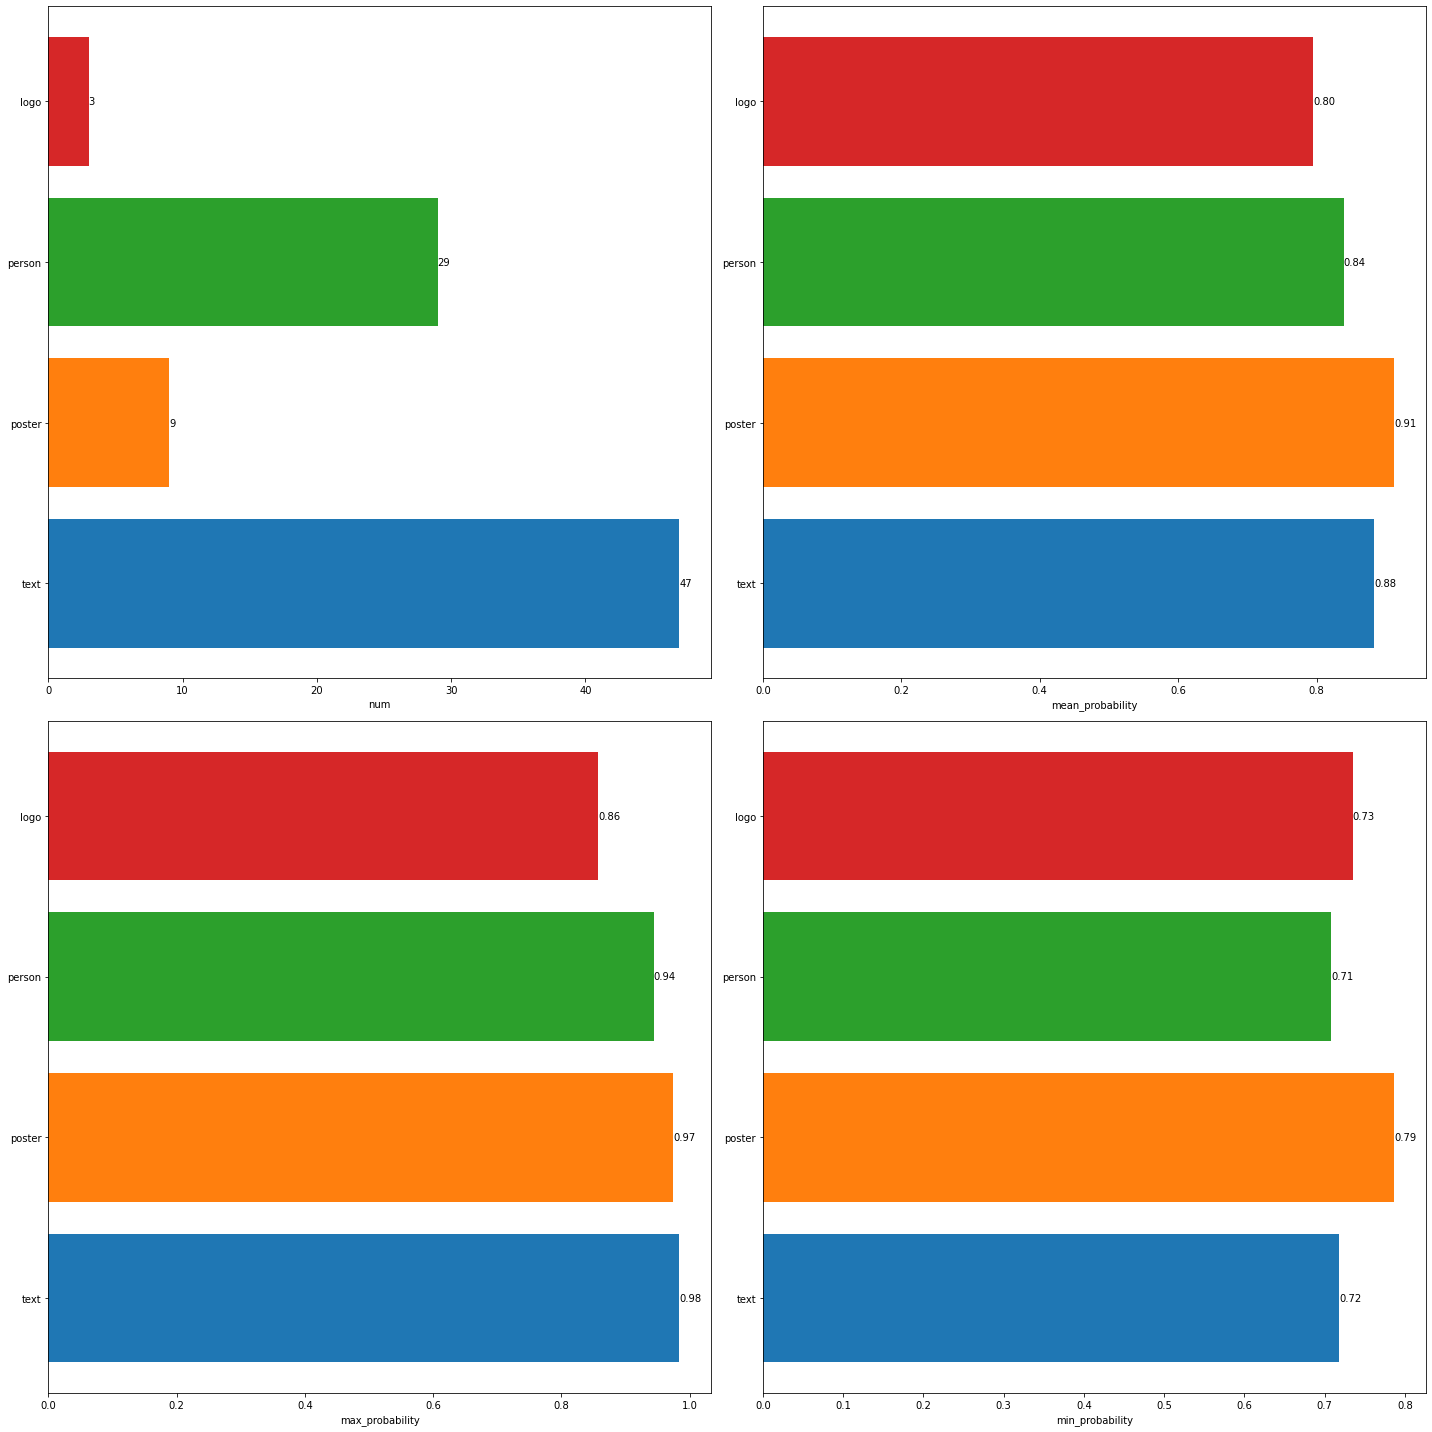

In [18]:
output_dict = {}
boxes_dict = {}
output_path = "./detections/{}/{}/".format(IMAGE_PATH.split("/")[-2], time.strftime("%d,%m,%Y-%H,%M"))
if not isdir(output_path):
    os.makedirs(output_path)

for count, element in enumerate(image_list):
    torch.cuda.empty_cache()
    picture = cv2.imread(IMAGE_PATH + element)
    predictor = DefaultPredictor(config)
    outputs = predictor(picture)

    predicted_classes = list(np.asarray(outputs["instances"].pred_classes.to("cpu")))
    prediction_scores = list(np.asarray(outputs["instances"].scores.to("cpu")))
    prediction_scores = [float(element) for element in prediction_scores]
    prediction_boxes = outputs["instances"].pred_boxes.to("cpu")
    prediction_boxes = [[int(value) for value in list(np.asarray(element))] for element in prediction_boxes]

    thing_classes = MetadataCatalog.get(config.DATASETS.TRAIN[0]).thing_classes
    predicted_classes_names = [thing_classes[element] for element in predicted_classes]

    output_dict[element] = {"category_names": predicted_classes_names, "prediction_scores": prediction_scores}
    boxes_dict[element] = {"category_names": predicted_classes_names, "prediction_boxes": prediction_boxes}

    print("[INFO] Predicted {}\t{}/{}".format(element, count+1, len(image_list)))

    if save_images:
        v = Visualizer(picture[:,:, ::-1], MetadataCatalog.get(config.DATASETS.TRAIN[0]), scale=1)
        out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        cv2.imwrite(output_path + element[:-4] + "_with_detections.jpg", out.get_image()[:, :, ::-1])

with open(output_path + "detections.json", "w+") as output_file:
    json.dump(output_dict, output_file, indent=4)

with open(output_path + "bounding_boxes.json", "w+") as output_file:
    json.dump(boxes_dict, output_file, indent=4)

prediction_analysis(output_path)